# Run QNet on Lander

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sys.path.append('RL_lib/Agents/PPO')
sys.path.append('RL_lib/Utils')
sys.path.append('../')

import QLearn
import env_lib
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
import utils
from env_gaudet_lander import LanderEnvironment, int_to_bin, bin_to_int

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed
PPO Policy 1

Instructions for updating:
Use keras.layers.dense instead.

Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Actions
[[0.]
 [1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0'])


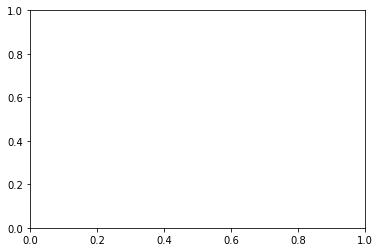

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

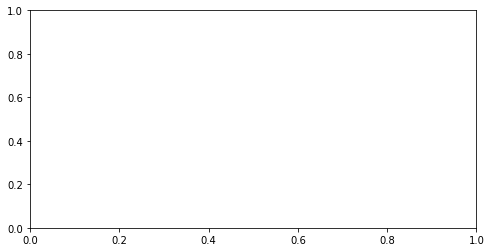

In [4]:
env = LanderEnvironment(reward_type='sparse')
obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True, discretize=True)

fname = "opt_discrete_4km"
input_normalizer = utils.load_run(policy,fname)

## Baseline Performances

In [23]:
def ppo_policy(s):
    s_norm = input_normalizer.apply(s)
    a = policy.sample(s_norm.reshape(1,-1))
    return bin_to_int(list(a[1][0]))

def random_policy(s):
    return np.random.randint(16)

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
queue fixed
Flat Constraint


In [24]:
R_rand, s_rand = QLearn.heuristic_demo(random_policy,env,100)

In [26]:
policy.test_mode=True
R_ppo, s_ppo = QLearn.heuristic_demo(ppo_policy,env,100)

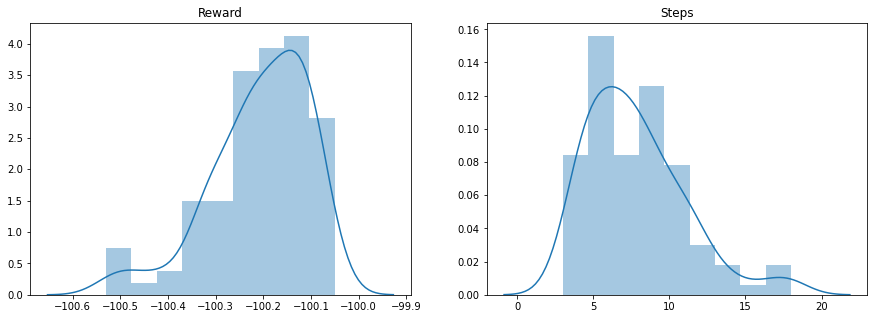

In [25]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(R_rand,ax=ax1)
_=plt.title('Reward')
ax2 = plt.subplot(122)
ax2 = sns.distplot(s_rand,ax=ax2)
_=plt.title('Steps')

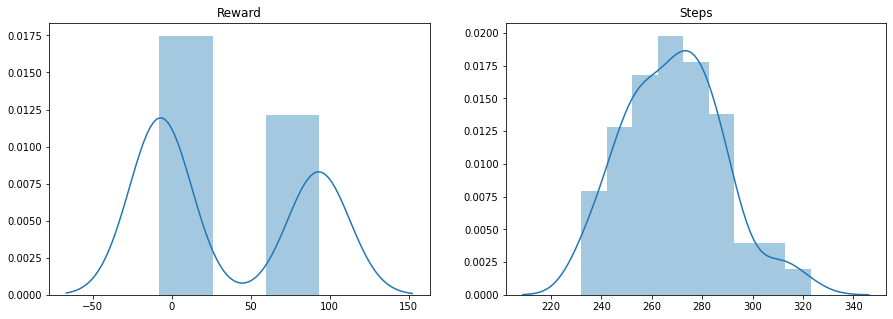

In [27]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(R_ppo,ax=ax1)
_=plt.title('Reward')
ax2 = plt.subplot(122)
ax2 = sns.distplot(s_ppo,ax=ax2)
_=plt.title('Steps')

In [28]:
R_ppo

[-6.929999999999978,
 92.48000000000003,
 -6.73999999999998,
 -7.2899999999999725,
 -7.049999999999973,
 -7.5099999999999705,
 93.02000000000002,
 93.34000000000002,
 93.24000000000001,
 93.02000000000002,
 -7.009999999999978,
 -6.689999999999979,
 93.26000000000002,
 -6.68999999999998,
 93.45000000000002,
 93.06000000000003,
 -6.969999999999974,
 -6.7999999999999865,
 -7.5299999999999665,
 93.39000000000001,
 -7.069999999999982,
 93.25000000000003,
 -7.009999999999982,
 92.61000000000003,
 -6.729999999999983,
 -6.669999999999975,
 -6.819999999999974,
 -6.769999999999982,
 -7.499999999999969,
 -6.679999999999982,
 -6.759999999999983,
 -7.009999999999973,
 93.00000000000003,
 93.34000000000002,
 92.68000000000002,
 92.86000000000003,
 -7.069999999999987,
 93.14000000000001,
 -6.849999999999982,
 -6.479999999999982,
 92.95000000000002,
 -6.889999999999976,
 93.06000000000003,
 93.29000000000002,
 93.12000000000002,
 -6.559999999999986,
 93.15000000000002,
 -7.7999999999999625,
 -6.959999

In [6]:
policy.test_mode=True
mem_ppo = QLearn.heuristic_memory_demo(ppo_policy,env,20,fname='demo_disc_sparse.pkl')

## Running Q Agent with Guidance

In [ ]:
N_ep = 2000
policy.test_mode=True
agent = QLearn.QAgent(env, net_type='QNet', f_heur=ppo_policy, n_heur=100,
                    update_steps=10, N_hid=100, eps0=0.9, gamma=0.99, n_eps=1500, memory_size=100000, minibatch_size=25)
R_ep, agent, env = do_run(agent, env, N_ep)

In [9]:
agent.nn.sess.close()

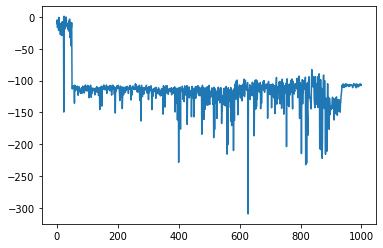

In [26]:
plt.plot(R_ep)

Using demo memory

In [19]:
del agent

In [ ]:
N_ep = 50000
dmem=pickle.load(open('demo_disc.pkl','rb'))
env = LanderEnvironment()
agent = QLearn.QAgent(env,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,eps0=0.25,n_eps=40000,minibatch_size=100,memory_size=500000,demo_memory=dmem,n_demo=100)
fname = 'lander_demo_test_24_3_0.pkl'
R, steps, agent, env = QLearn.do_run(agent, env, N_ep, save_name = fname, show_progress=True)

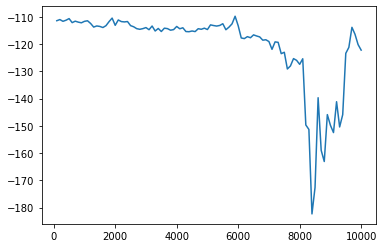

In [18]:
x,R_s=R.smooth()
plt.plot(x,R_s)

Showing example runs

In [4]:
data_all = []
for i in range(8):
    data_all.append(pickle.load(open('test_demo_21_3_{}.pkl'.format(i),'rb')))
print(['{}: {}'.format(i,np.mean(r['R'][-100:]).round(1)) for i, r in enumerate(data_all)])

['0: -138.6', '1: -161.7', '2: -133.7', '3: -123.0', '4: -140.8', '5: -122.6', '6: -193.8', '7: -121.0']


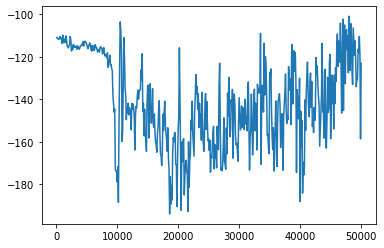

In [5]:
run_no = 3

x,R = data_all[run_no]['R'].smooth()
plt.plot(x,R)

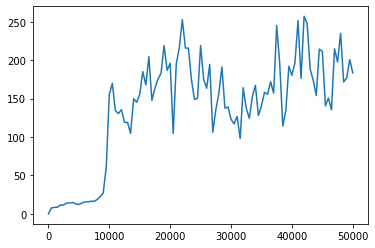

In [12]:
run_no = 3

steps = data_all[run_no]['step']
x,s_avg = QLearn.data_smooth(steps,500)
plt.plot(x,s_avg)

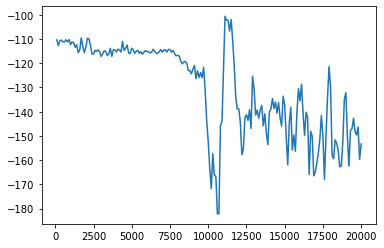

In [15]:
data_samp = pickle.load(open('lander_demo_test_20_3_mlp1.pkl','rb'))
x,R = data_samp['R'].smooth()
plt.plot(x,R)

## Using Prioritised Experience Replay

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed


*** ATT VIO TYPE CNT:  [0. 1. 0.]
*** ATT VIO TYPE CNT:  [ 0. 24. 77.]
*** ATT VIO TYPE CNT:  [  0.  72. 130.]
*** ATT VIO TYPE CNT:  [  0.  97. 205.]
*** ATT VIO TYPE CNT:  [  0. 122. 280.]
*** ATT VIO TYPE CNT:  [  0. 164. 340.]
*** ATT VIO TYPE CNT:  [  0. 175. 430.]
*** ATT VIO TYPE CNT:  [  0. 208. 497.]
*** ATT VIO TYPE CNT:  [  0. 242. 565.]
*** ATT VIO TYPE CNT:  [  0. 286. 621.]
*** ATT VIO TYPE CNT:  [  0. 292. 715.]
*** ATT VIO TYPE CNT:  [  0. 307. 800.]
*** ATT VIO TYPE CNT:  [  0. 309. 898.]
*** ATT VIO TYPE CNT:  [  0. 329. 978.]
*** ATT VIO TYPE CNT:  [   0.  329. 1078.]
*** ATT VIO TYPE CNT:  [   0.  329. 1178.]
*** ATT VIO TYPE CNT:  [   0.  339. 1268.]
*** ATT VIO TYPE CNT:  [   0.  439. 1268.]
*** ATT VIO TYPE CNT:  [   0.  539. 1268.]
*** ATT VIO TYPE CNT:  [   0.  639. 1268.]
*** ATT VIO TYPE CNT:  [   0.  739. 1268.]
*** ATT VIO TYPE CNT:  [   0.  839. 1268.]
*** ATT VIO TYPE CNT:  [   0.  865. 1342.]
*** ATT VIO TYPE CNT:  [   0.  865. 1442.]
*** ATT VIO TYPE CN

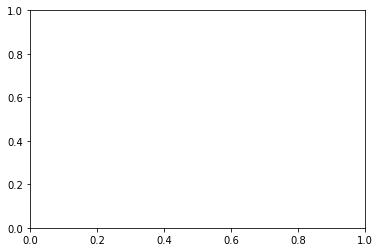

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

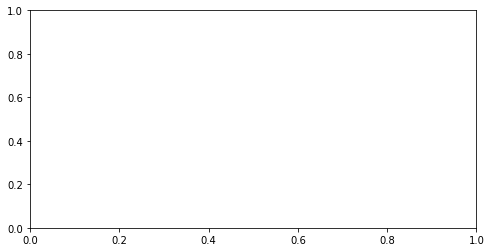

In [13]:
N_ep = 5000
dmem=pickle.load(open('demo_disc.pkl','rb'))
env = LanderEnvironment()
agent = QLearn.PerQAgent(env,demo_memory=dmem,net_type='MLPQNet',hidden_layers=[160, 80],alpha=1e-4,gamma=0.99,
                         eps0=0.5,n_eps=3000,minibatch_size=100,capacity=100000)
fname = 'lander_per_13_4_1.pkl'
R, steps, agent, env = QLearn.do_run(agent, env, N_ep, save_name = fname, show_progress=True)

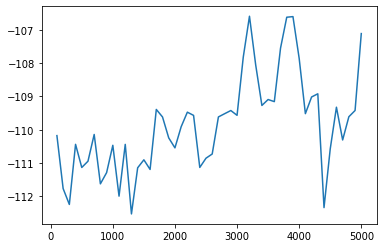

In [14]:
x,R_s=R.smooth()
plt.plot(x,R_s)

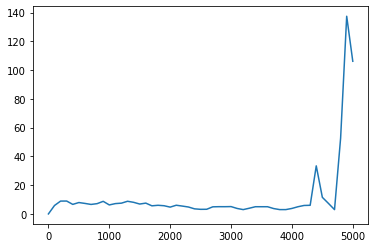

In [15]:
x,s_avg = QLearn.data_smooth(steps,100)
plt.plot(x,s_avg)